# Preparatory activities

In this section preparatory activities are performed.

The first step is to load all packages needed. The package `dexplo` contains all custom functions, which are required in this task.

> **Note:**
>
> All answers refer to the data sample

In [1]:
import geopandas as gp
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from pymongo import MongoClient
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# plotly imports
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# custom functions
import dataExplorationFunctions as dexplo

Next, a connection to the MongoDb database is established.

In [2]:
client = MongoClient('mongodb://localhost:27017/')
db = client["stepstone-data"]

The last preparatory step is to retrieve the data from every MongoDb collection in `stepstone-data`. The document id `_id` (generated by MongoDb) is hidden.

In [3]:
# get sector data
sectorDf = pd.DataFrame(list(db.sectors.find({},{"_id":0})))

# get company data
companyDf = pd.DataFrame(list(db.pCompany.find({},{"_id":0})))

# get job data
jobDf = pd.DataFrame(list(db.pJobs.find({},{"_id":0})))

# get job tokens
jobTokens = pd.DataFrame(list(db.tmJobs.find({},{"_id":0})))

# get county data
countyData = pd.DataFrame(list(db.counties.find({},{"_id":0})))

# Analysis of the job properties

This section should answer the question: **What are the characteristics/properties of data science jobs?**

The following aspects are analyzed:
* Work type
* Contract type
* Benefits
* Applicant profile
* Tasks

## Work type

This subsection analyzes the different types of work. Each job can be full-time, part-time and/or home office. The different work types are stored in a single string separated by a comma. For the analysis, the work types must first be extracted from the string.

In [4]:
set(jobDf["workType"])

{'Home Office möglich',
 None,
 'Teilzeit',
 'Teilzeit, Home Office möglich',
 'Vollzeit',
 'Vollzeit, Home Office möglich',
 'Vollzeit, Teilzeit',
 'Vollzeit, Teilzeit, Home Office möglich'}

In [5]:
# copy the original data frame
workTypeAnalysis = jobDf.copy()

# extract the possible work types to a list
workTypeAnalysis["workType"] = workTypeAnalysis["workType"].apply(lambda x: [item.strip() for item in x.split(",")] if type(x)==str else [None])

# calculate jobs per work type
workTypeAnalysis = (workTypeAnalysis.explode("workType")
                                    .groupby("workType")
                                    .count()["jobId"]
                                    .rename("numberOfJobs"))

# plot results
fig = px.bar(workTypeAnalysis.sort_values(), 
             x="numberOfJobs", 
             text="numberOfJobs", 
             template="simple_white",
             title="Work Types", 
             orientation="h")

# update traces
fig.update_traces(textposition="outside", marker_color="#0c2577", hoverinfo="skip", hovertemplate=None)

# update axes
fig.update_yaxes(title=None)
fig.update_xaxes(title=None, tickangle = 0)

# update layout
fig.update_layout(barmode='stack')

# show plot
fig.show()

The visualization shows that full-time work is possible for the most jobs. In contrast, part-time work is only possible for few jobs.

## Contract type

Each job can have different contract types. This subsection answers the question: How common are the different contract types in data science jobs?

The different contract types are stored in a single string separated by a comma. For the analysis, the contract types must be extracted from the string.

In [6]:
set(jobDf["contractType"])

{'Arbeitnehmerüberlassung',
 'Ausbildung, Studium',
 'Bachelor-/Master-/Diplom-Arbeiten',
 'Bachelor-/Master-/Diplom-Arbeiten, Praktikum',
 'Befristeter Vertrag',
 'Berufseinstieg/Trainee',
 'Feste Anstellung',
 'Feste Anstellung, Befristeter Vertrag',
 'Feste Anstellung, Berufseinstieg/Trainee',
 'Freie Mitarbeit/Projektmitarbeit',
 None,
 'Praktikum',
 'Praktikum, Studentenjobs, Werkstudent',
 'Promotion/Habilitation',
 'Studentenjobs, Werkstudent'}

In [30]:
# copy the original data frame
contrTypeAnalysis = jobDf.copy()

# extract the possible contract types to a list
contrTypeAnalysis["contractType"] = contrTypeAnalysis["contractType"].apply(lambda x: [item.strip() for item in x.split(",")] if type(x)==str else [None])

# calculate jobs per contract type
contrTypeAnalysis = (contrTypeAnalysis.explode("contractType")
                                      .groupby("contractType")
                                      .count()["jobId"]
                                      .rename("numberOfJobs"))

# plot results
fig = px.bar(contrTypeAnalysis.sort_values(),
             x="numberOfJobs",
             text="numberOfJobs",
             template="simple_white",
             title="Contract Types", 
             orientation="h")

# update traces
fig.update_traces(textposition="outside", marker_color="#0c2577", hoverinfo="skip", hovertemplate=None)

# update axes
fig.update_yaxes(title=None)
fig.update_xaxes(title=None, tickangle = 0)

# update layout
fig.update_layout(barmode='stack')

# show plot
fig.show()

You can see that most of the positions offer permanent employment. Only a few positions (39) are temporary. The reason for this could be that it is more difficult to attract Data Scientists with a temporary contract than other professions. It is also interesting that there are only few positions for students and beginners (e. g. trainee). One explanation could be that work experience is required for the job tasks as data scientist. Maybe, another explanation could be that data science jobs for beginners are generally not posted on Step Stone, only on the website of the respective company, because offering on Step Stone is really expensive for companies.

## Benefits

This subsection analyzes the benefits offered in data science jobs. A job can have more than one benefit. The following visualization shows the 10 most common benefits.

In [8]:
# explode method
benefitAnalysis = (jobDf.explode("benefits")
                        .groupby("benefits", as_index=False)["jobId"]
                        .count().rename(columns={"jobId":"absolute"})
                        .sort_values(by="absolute", ascending=False)
                        .head(10))

# calculate relative frequency
numberOfJobs = jobDf.shape[0]
benefitAnalysis["relative"] = round(benefitAnalysis["absolute"] / numberOfJobs * 100,0).astype(int)

# calculate bar chart
fig = px.bar(benefitAnalysis.sort_values(by="absolute"),
             y="benefits", 
             x="relative",
             text="relative",
             template="simple_white",
             title="Top 10 benefits in data science jobs in percent (%)", 
             orientation="h")

# update traces
fig.update_traces(textposition="outside", marker_color="#0c2577", hoverinfo="skip", hovertemplate=None)

# update axes
fig.update_yaxes(title=None)
fig.update_xaxes(title=None, tickangle = 0)

# update layout
fig.update_layout(barmode='stack')

# show plot
fig.show()

The bar chart shows that more than 50 percent of data science jobs offer flexible working hours. This is not surprising, because the tasks of data science allow for this. The same argument applies to home office, which ranks fifth. Other common benefits include retirement benefits, joint events or discounts for employees.

## Applicant profiles

This subsection contains the analysis of the requirements which the applicants for data science jobs should have. The tokens and token combinations were identified in the text mining part of this project. Now, the words are visualized by using a word cloud. Then, they are discussed.

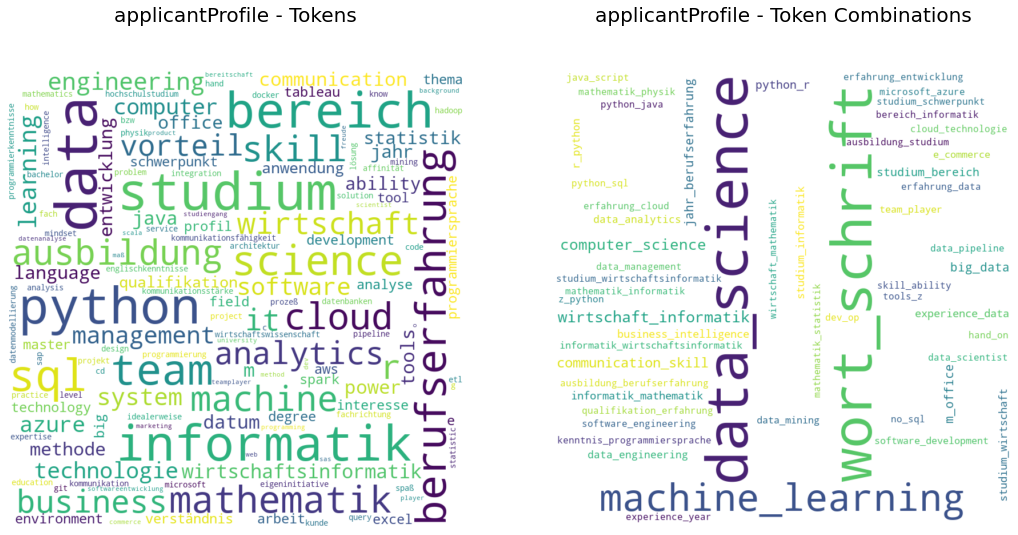

In [31]:
# create plot object
plt.figure(figsize=(18,10))

# create subplot
plt.subplot(1,2,1)
wordcloud = dexplo.createWordCloud(jobTokens,"applicantProfile")
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("applicantProfile - Tokens", fontsize=20, pad=50)
plt.axis('off')

# create subplot
plt.subplot(1,2,2)
wordcloud = dexplo.createWordCloud(jobTokens,"applicantProfileComb")
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("applicantProfile - Token Combinations", fontsize=20, pad=50)
plt.axis('off')

# show plot
plt.show()

The left word cloud visualizes the tokens of the applicant profile. The large token **"studium"** indicates that many data science jobs require a study degree. The tokens **"informatik"** and **"mathematik"** are also large. These tokens could be required study degrees in many data science jobs. The large token **"berufserfahrung"** could indicate that work experience is required in many data science jobs. This is consistent with the fact that there are few beginner and student jobs (see contract type subsection). The tokens also include technical skills such as **"python"** and **"sql"** which are required in many jobs. Concerning the font size, you can see that the programming language **"python"** is required in more jobs than the programming language **"r"**.

The right word cloud visualizes the token combinations of the applicant profile. Three token combinations are clearly visible. The first one is the token combination **"wort_schrift"** which could be associated with language skills. The second is the token combination **"machine_learning"**, which represents a technical skill. The token combination **"data_sience"** represents the whole area of the topic.

> **Note:** 
>
> The empty space between the tokens of a token combination is replaced with an _ for better readability.

## Tasks

In this subsection, the tasks of data science jobs are analyzed. The tokens and token combinations were determined in the text mining part. Now, the words are visualized by using a word cloud. Then, they are discussed.

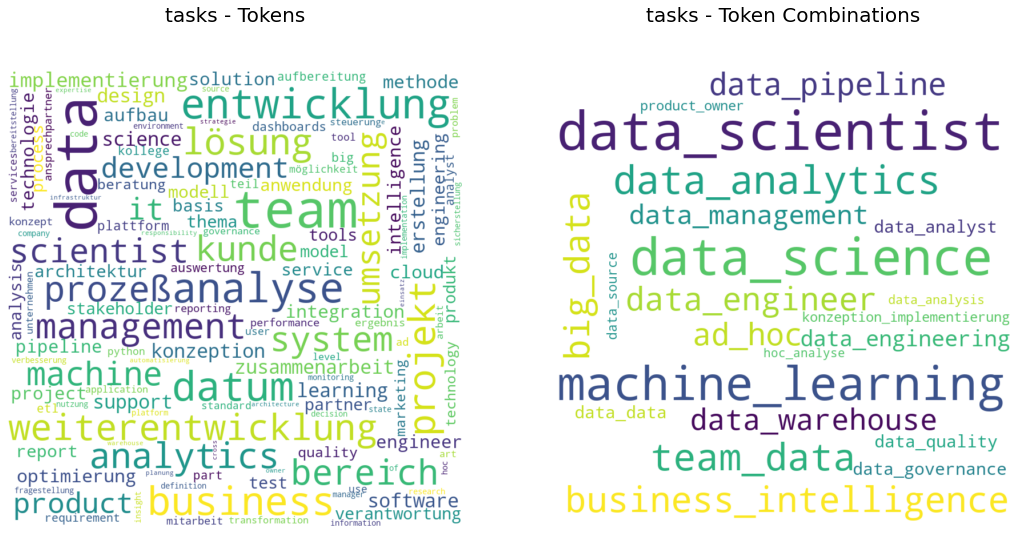

In [10]:
# create plot object
plt.figure(figsize=(18,10))

# create subplot
plt.subplot(1,2,1)
wordcloud = dexplo.createWordCloud(jobTokens,"tasks")
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("tasks - Tokens", fontsize=20, pad=50)
plt.axis('off')

# create subplot
plt.subplot(1,2,2)
wordcloud = dexplo.createWordCloud(jobTokens,"tasksComb")
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("tasks - Token Combinations", fontsize=20, pad=50)
plt.axis('off')

# show plot
plt.show()

The left word cloud visualizes the tokens of the tasks. Some important (large) tokens are discussed in detail:
* The token **"data"** is the subject area around which everything revolves.
* The token **"team"** may mean that many data science tasks are done in teams.
* The token **"entwicklung"** possibly indicates the software to be developed.
* The token **"projekt"** may show that projects are important in data science.

The word cloud on the right shows the token combinations of the tasks - many of the large token combinations represent data science topics (e.g., **"machine_learning"**, **"big_data"**, **"business_intelligence"**, **"data_pipeline"**).

# Analysis of the companies

This section analyzes the properties of companies which offer data science jobs. 

This section should answer the question: **Which companies offer jobs in data science?"**

## Number of workers

A very important characteristic of a company is its size in terms of the number of employees.

Stepstone divides the companies into intervals depending on the number of employees (ordinal variable). The problem is that there are overlapping intervals in the data (e.g. 51-250, 201-500, 251-500). Non-overlapping intervals are defined in order to solve this problem. Only companies which fit in one of these intervals are analyzed.

In [11]:
# create a copy of the company data frame
workerAnalysis = companyDf.copy()

# modify the worker column
workerAnalysis["workers"] = workerAnalysis["workers"].apply(lambda x: '{}-{}'.format(x[0], x[1]))

# mapping data frame with all relevant groups and workerOrder for sorting
workCat = [['1-10',1],
           ['11-50',2],
           ['51-250',3],
           ['251-500',4],
           ['501-1000',5],
           ['1001-2500',6],
           ['2501-5000',7],
           ['5001-10000',8],
           ['10001-None',9]]

colNames = ["workers", "workerOrder"]
workCatDf = pd.DataFrame(data=workCat, columns=colNames)

# join the mapping table to the worker analysis data frame
workerAnalysis = pd.merge(workerAnalysis, workCatDf, how="inner")

# join the jobs tabele to worker analysis data frame
workerAnalysis = pd.merge(workerAnalysis, jobDf, on="companyId", how="inner")
workerAnalysis = workerAnalysis.groupby(["workers", "workerOrder"]).count()["jobId"].rename("numberOfJobs")
workerAnalysis = workerAnalysis.sort_index(level=1)

# create bar plot
fig = px.bar(workerAnalysis, 
             x=workerAnalysis.index.get_level_values(0), 
             y="numberOfJobs",
             text="numberOfJobs",
             template="simple_white",
             title="Offered data science jobs per employees")

# update traces
fig.update_traces(textposition="outside", marker_color="#0c2577", hoverinfo="skip", hovertemplate=None)

# update axes
fig.update_xaxes(title=None)

# show plot
fig.show()

The figure shows that the most jobs in Data Science are offered in companies with more than 10.000 employees. Only few jobs are offered in small companies. Perhaps, smaller companies offer jobs more frequently by using other channels (not Step Stone).

## Sectors

Companies can operate in various sectors. This subsection identifies which sectors have the most data science jobs.

In [12]:
# get distinc company sectors
sectorAnalysis = companyDf.explode("sectors")[["companyId","sectors"]].rename(columns={"sectors":"sectorId"})

# join sector names
sectorAnalysis = pd.merge(sectorAnalysis, sectorDf, how="inner").rename(columns={"name":"sectorName"})

# join jobs
sectorAnalysis = pd.merge(sectorAnalysis, jobDf, how="inner")

# aggregate
sectorAnalysis = sectorAnalysis.groupby("sectorName")["jobId"].count().rename("numberOfJobs")

# filter top 155
sectorAnalysis = sectorAnalysis.sort_values(ascending=False).head(10)

# create plotly chart
fig = px.bar(sectorAnalysis.sort_values(),
             x="numberOfJobs",
             text="numberOfJobs",
             template="simple_white",
             title="Top 10 sectors with the most job offers",
             orientation="h")

# update traces
fig.update_traces(textposition="outside", marker_color="#0c2577", hoverinfo="skip", hovertemplate=None)

# update axes
fig.update_yaxes(title=None)
fig.update_xaxes(title=None, tickangle = 0)

# update layout
fig.update_layout(barmode='stack')

# show plot
fig.show()

The bar chart shows the 10 sectors with the most data science jobs. The **"IT and Internet"** sector provides the most data science jobs, which is not surprising. Other large sectors are for example **"consulting"** and **"vehicle manufacturing"**.

# Geographic analysis

After explore the data in previous analysis, we want to create maps too. We collected location data from companies and job offers and are going to visualize them.

There are different questions we want to answer, like:

* Which region hosts companies searching for these jobs?
* Which region demands most of described jobs?
* Is there a correlation between *socioeconomic data* and *job offers*?

Although we collected many job offers and companies all around the world, we focus on jobs/companies in Germany. This will improve data visualization.

First, we need to prepare data. The data are provided as type of *DataFrame* (*sectorDf*, *companyDf*, *jobDf*)

There are several functions available in `data-explorationFunctions.py`, which are going to prepare the data.

For creating a map, we are going to use *Shapefiles* because we mapped location data with an ARS key. A documentation for this ARS key can be found at [Destatis](https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/_FAQ/regionalschluessel.html)

The shapefiles can be downloaded under this link -> [Bund.de](https://gdz.bkg.bund.de/index.php/default/open-data/verwaltungsgebiete-1-250-000-ebenen-stand-01-01-vg250-ebenen-01-01.html)

> **Note:**
> 
> It is not clear, wether the federal state "Berlin" is part of "West Germany" or "East Germany". We've decided, that "Berlin" is located in "East Germany". It is only based on geographic and not on any socioeconomic or historical aspects.

> **Important note reg. shape files:**
>
> Due the fact, that the shapefiles are pretty detailed, we decided to simplify the shape file `VG250_KRS.shp` by using the online tool [Mapshaper](https://mapshaper.org/). 
> 
> This allowed us to reduce the shape size by 97.5%.
> 
> The new shape files are named as `VG250_KRS_simplified.shp`.

In [13]:
# load shape file for map visualization
shape = gp.read_file("mapData/vg250_01-01.gk3.shape.ebenen/vg250_ebenen_0101/VG250_KRS_simplified.shp")
shape = shape.to_crs(epsg=4326)

# modify shapefile to get federal state
shape = dexplo.expandState(shape)

# create geoJSON file (uncomment to create file)
# shape.to_file("mapData/VG250_KRS.geojson", driver='GeoJSON')

## Which region hosts more companies searching for these jobs?

First, we want to know, where all companies are located and if there are regional discrepancies. For this purpose, we created a simple *Scatter Map*. Each dot represents a single company and hovering this point will show the company name and the GPS data as well.

In [34]:
# convert company locations
companyLocations = dexplo.transformLocation(companyDf[["companyId","companyName", "location"]])

# merge shape and company locations
companyLocations = pd.merge(companyLocations, shape, how="left", left_on="AGS", right_on="AGS", suffixes=(None, "_shape"))

# create figure object
figCompLocs = px.scatter_mapbox(companyLocations,
                                lat="latitude",
                                lon="longitude",
                                hover_name="companyName",
                                hover_data=["city", "federalState", "region"],
                                zoom=5,
                                center=dict(lat=51.08342, lon=10.42345))

# update traces
figCompLocs.update_traces(marker=go.scattermapbox.Marker(size=8, color="#0c2577"))

# update geos
figCompLocs.update_geos(scope="europe")

# update layout
figCompLocs.update_layout(mapbox_style="carto-positron",
                          height=600,
                          autosize=True,
                          margin={"r": 0, "t": 0, "l": 0, "b": 0},
                          paper_bgcolor="#303030",
                          plot_bgcolor="#303030")

# show map
figCompLocs.show()

Most companies, which are searching for Data Scientists are located in metropolitan areas in West-Germany. For example there are many markers around the cities of:

* Munich (München)
* Stuttgart
* Franfurt am Main
* Ruhrgebiet (Düsseldorf, Cologne (Köln), ...)
* Hannover
* Hamburg

Only Berlin has a concentration of companies, who are located in East-Germany.

This is verified by following plots, which are showing the absolute (total number of companies) and relative (number of company/1M inhabitants) companies per region.

In [15]:
# create absolute + relative
absCompany = companyLocations.groupby("region").count().reset_index()[["region", "companyId"]]
relCompany = companyLocations.groupby(["region", "AGS"]).count().reset_index()[["region", "companyId", "AGS"]]

# calculate relCompany (relative) with population data
relCompany = pd.merge(countyData, relCompany, how="left", left_on="countyId", right_on="AGS", suffixes=(None, "_county"))
relCompany = relCompany.groupby("region").agg({"population": "sum", "companyId": "sum"}).reset_index()
relCompany["rel"] = relCompany["companyId"] / relCompany["population"] * 1000000

# create subplots
figCompSubplot = make_subplots(rows=1, cols=2, subplot_titles=["Total companies", "Companies per 1M inhabitants"])

# subplot 1 -> bar chart (absolute counts)
figCompSubplot.add_trace(go.Bar(x=absCompany.region, 
                                y=absCompany.companyId, 
                                marker_color="#0c2577",
                                text=absCompany.companyId), col=1, row=1)

# subplot 2 -> bar chart (relative counts)
figCompSubplot.add_trace(go.Bar(x=relCompany.region, 
                                y=relCompany.rel, 
                                marker_color="#0c2577",
                                text=relCompany.rel.round(3)), col=2, row=1)

# update traces
figCompSubplot.update_traces(textposition="outside", hoverinfo="skip")

# update layout
figCompSubplot.update_layout(title_text="Comparission of West Germany and East Germany (absolute/relative)",
                             title_x=0.5,
                             showlegend=False,
                             template="simple_white")

# show plot
figCompSubplot.show()

Afterall, our hypothesis can be verified by both plots. The left plot shows us the absolute number of companies in West Germany. It is visible, that there are far more companies located in West Germany than in East Germany searching for *Data Scientists*. Even the right plot shows us, that this assumption is correct. Calculating the relative number of companies per 1 million inhabitants shows us, that there are twice as much companies in West Germany than in East Germany. 

## Which region demands most of described jobs?

After we investigated the geografic locations of searching companies, we want to know, where the jobs are located. Many big companies do have different sites (e.g. *Bosch* have sites in Stuttgart, Schwieberdingen, Renningen, Leonberg, ...).

In [36]:
# convert company locations
jobLocations = dexplo.transformLocation(jobDf[["jobId","company", "title", "location"]])

# merge shape and company locations
jobLocations = pd.merge(jobLocations, shape, how="left", left_on="AGS", right_on="AGS", suffixes=(None, "_shape"))

# create figure object
figJobLocs = px.scatter_mapbox(jobLocations,
                               lat="latitude",
                               lon="longitude",
                               hover_name="company",
                               hover_data=["title", "jobId", "city", "federalState", "region"],
                               zoom=5,
                               center=dict(lat=51.08342, lon=10.42345))

# update traces
figJobLocs.update_traces(marker=go.scattermapbox.Marker(size=8, color="#0c2577"))

# update geos
figJobLocs.update_geos(scope="europe")

# update layout
figJobLocs.update_layout(mapbox_style="carto-positron",
                          height=600,
                          autosize=True,
                          margin={"r": 0, "t": 0, "l": 0, "b": 0},
                          paper_bgcolor="#303030",
                          plot_bgcolor="#303030")

# show map
figJobLocs.show()

If we compare the results from *4.1 - Which region hosts more companies searching for these jobs?* and this result, we can see, that there is almost no difference. Most jobs are searched in the metropolitan areas in West Germany and Berlin.

To validate this thesis, we are creating 2 plots. These plots shows us the absolute and relative distribution of jobs along the geografic location *West Germany* and *East Germany*.

In [17]:
# create absolute + relative
absJob = jobLocations.groupby("region").count().reset_index()[["region", "jobId"]]
relJob = jobLocations.groupby(["region", "AGS"]).count().reset_index()[["region", "jobId", "AGS"]]

# calculate relJob (relative) with population data
relJob = pd.merge(countyData, relJob, how="left", left_on="countyId", right_on="AGS", suffixes=(None, "_county"))
relJob = relJob.groupby("region").agg({"population": "sum", "jobId": "sum"}).reset_index()
relJob["rel"] = relJob["jobId"] / relJob["population"] * 1000000

# create subplots
figJobSubplot = make_subplots(rows=1, cols=2, subplot_titles=["Total jobs", "Jobs per 1M inhabitants"])

# subplot 1 -> bar chart (absolute counts)
figJobSubplot.add_trace(go.Bar(x=relJob.region,
                               y=relJob.jobId,
                               marker_color="#0c2577",
                               text=relJob.jobId), col=1, row=1)

# subplot 2 -> bar chart (relative counts)
figJobSubplot.add_trace(go.Bar(x=relJob.region,
                               y=relJob.rel,
                               marker_color="#0c2577",
                               text=relJob.rel.round(3)), col=2, row=1)

# update traces
figJobSubplot.update_traces(textposition="outside", hoverinfo="skip")

# update layout
figJobSubplot.update_layout(title_text="Absolute/Relative distribution of open data scientist positions",
                            title_x=0.5,
                            showlegend=False,
                            template="simple_white")

# show plot
figJobSubplot.show()

The graphs above shows, that there are more *Data Scientist* jobs offered in West Germany than in East Germany. In absolute numbers, there are 5 times more *Data Scientist* jobs in the West than in the East. However, this numbers do have only a limited meaning due the fact, as there are considerably more inhabitants in West Germany than in East Germany.

If we compare the relative jobs per 1M inhabitants, there are slightly more jobs in West Germany than in East Germany.

##  Is there a correlation between socioeconomic data and job offers?

To answer this question, we want to consider each of the following variables individually:

* GDP per Capita
* Unemployment rate
* Population density

Therefore we create a further column, which shows the correlation. This correlation is calculated from `jobs per region` and one of the socioeconomic variables.

The correlation is displayed as scatter plot with a trendline and as choropleth map showing the correlation as continuous variable.

> **Note:**
>
> Not all regions are displayed in the choropleth maps, because there are no job offers for *Data Scientists* in these regions.

First, we prepare the data by removing unnecessary columns and creating calculated columns like `jobs per 1M` (jobs per 1M inhabitants) or `popDensity` (population density).

In [18]:
# transform locations
_seData = dexplo.transformLocation(jobDf[["jobId","company", "title", "location"]])[["jobId", "AGS"]]

# group by AGS
_seData = _seData.groupby("AGS").count().reset_index()

# join with shape and countyData
_seData = pd.merge(_seData, shape[["AGS", "GEN", "BEZ", "geometry", "federalState", "region"]], how="right", left_on="AGS", right_on="AGS", suffixes=(None, "shape"))
_seData = pd.merge(_seData, countyData[["countyId", "gdpPerCapita", "unemploymentRate", "population", "areaSize"]], how="left", left_on="AGS", right_on="countyId", suffixes=(None, "county"))

# rename columns
_seData = _seData.rename(columns={"jobId": "numberOfJobs"})

# replace NaN in 'numberOfJobs'
_seData["numberOfJobs"] = _seData["numberOfJobs"].fillna(0)

# calculate jobs per 1M inhabitants
_seData["jobs_per_1M"] = _seData["numberOfJobs"] / _seData["population"] * 1000000

# calculate population density
_seData["popDensity"] = _seData["population"] / _seData["areaSize"]

# convert type of AGS
_seData["AGS"] = _seData["AGS"].astype("string")

# create a geo dataframe as well
_seDataGDF = gp.GeoDataFrame(_seData)

### GDP per Capita

This metric is used to display the average economic output per person. In this section we want to check, wether there is a correlation between **GDP per Capita** and **jobs per 1M inhabitants**.

In [43]:
# create scatter plot
scatterGDP = px.scatter(_seData,
                        x="gdpPerCapita",
                        y="jobs_per_1M",
                        color="region",
                        color_discrete_map={"East Germany": "#7aae1a", "West Germany": "#0c2577"},
                        opacity=0.9,
                        trendline="ols",
                        labels={"gdpPerCapita": "GDP per Capita in EUR",
                                "jobs_per_1M": "Jobs per 1M inhabitants",
                                "region": "Region"})

# update layout
scatterGDP.update_layout(title_text="Correlation of 'GDP per Capita' and 'Jobs per 1M inhabitants'",
                         title_x=0.5,
                         template="plotly_white")

# show plot
scatterGDP.show()

The graph shows, that there is a positive correlation between both variables. Counties with a high gross domestic product per capita tend to have more data science jobs. This effect is particularly evident in West German counties.

### Unemployment rate

Within all socioeconomic metrics, the value of *unemployment rate* is most interesting. It displays the relation of how many persons are unemployed and employed. This value is given mostly in percent (%) like in this case. Therefore we want to check, if there is a correlation between *Unemployment rate* and *Jobs per 1M inhabitants*. 

In [45]:
# create scatter plot
scatterUR = px.scatter(_seData,
                        x="unemploymentRate",
                        y="jobs_per_1M",
                        color="region",
                        color_discrete_map={"East Germany": "#7aae1a", "West Germany": "#0c2577"},
                        opacity=0.9,
                        trendline="ols",
                        labels={"unemploymentRate": "Unemployment Rate in %",
                                "jobs_per_1M": "Jobs per 1M inhabitants",
                                "region": "Region"})

# update layout
scatterUR.update_layout(title_text="Correlation of 'Unemployment rate' and 'Jobs per 1M inhabitants'",
                         title_x=0.5,
                         template="plotly_white")

# show plot
scatterUR.show()

The scatter plot shows that there is not a visible relationship between the *Unemployment rate* and *Jobs per 1M inhabitants*. This does not indicate that counties with a high unemployment rate have fewer data science jobs.

### Population density

*Population density* is a further metric, which is used often. We want to answer the question if there is a correlation between *Population density* and *Jobs per 1M inhabitants*.

In [46]:
# create scatter plot
scatterPD = px.scatter(_seData,
                        x="popDensity",
                        y="jobs_per_1M",
                        color="region",
                        color_discrete_map={"East Germany": "#7aae1a", "West Germany": "#0c2577"},
                        opacity=0.9,
                        trendline="ols",
                        labels={"popDensity": "Population density per km²",
                                "jobs_per_1M": "Jobs per 1M inhabitants",
                                "region": "Region"})

# update layout
scatterPD.update_layout(title_text="Correlation of 'Population density' and 'Jobs per 1M inhabitants'",
                         title_x=0.5,
                         template="plotly_white")

# show plot
scatterPD.show()

The scatter plot shows that there is a slightly positive relationship between *Population density* and *Jobs per 1M inhabitants*. That means that there are more data science jobs in urban counties than in rural counties. However, the relationship is weak and more visible in West Germany.

### Interactive map

Below, you will find an interactive map, which allows you to explore the map of Germany by displaying different socioeconomic data and *Jobs per 1M inhabitants* and *Total jobs* as well. 

Use the buttons to switch between different data to show. Please note, that a more intense color will display a higher value (data value: 0% = "white", 100% = "blue").

> **Note:**
>
> Counties with no jobs available are displayed with `numberOfJobs = 0`.

In [105]:
# create choropleth map
choroGDP = px.choropleth(_seDataGDF,
                         geojson=_seDataGDF,
                         locations="AGS",
                         featureidkey="properties.AGS",
                         color="jobs_per_1M",
                         projection="mercator",
                         hover_data=["numberOfJobs", "GEN", "federalState", "region", "gdpPerCapita"],
                         color_continuous_scale=["#ffffff", "#0c2577"],
                         title="Jobs per 1M inhabitants",
                         labels={"jobs_per_1M": "Jobs per 1M inhabitants",
                                 "numberOfJobs": "Total jobs",
                                 "GEN": "County",
                                 "federalState": "Federal state",
                                 "region": "Region",
                                 "gdpPerCapita": "GDP per capita"})

# update geos
choroGDP.update_geos(fitbounds="locations", visible=False)



# update layout
choroGDP.update_layout(updatemenus=[{"type": "buttons",
                                     "buttons": [{"args": [{"z": [ _seDataGDF["jobs_per_1M"] ]}, 
                                                           {"title.text": "Jobs per 1M inhabitants"}],
                                                  "label": "Jobs per 1M inhabitants",
                                                  "method": "update"},
                                                 {"args": [{"z": [ _seDataGDF["numberOfJobs"] ]}, 
                                                           {"title.text": "Total number of Jobs"}],
                                                  "label": "Number of Jobs",
                                                  "method": "update"},
                                                 {"args": [{"z": [ _seDataGDF["gdpPerCapita"] ]}, 
                                                           {"title.text": "GDP per Capita in EUR"}],
                                                  "label": "GDP per capita",
                                                  "method": "update"},
                                                 {"args": [{"z": [ _seDataGDF["unemploymentRate"] ]}, 
                                                           {"title.text": "Unemployment rate in %"}],
                                                  "label": "Unemployment rate",
                                                  "method": "update"},
                                                {"args": [{"z": [ _seDataGDF["popDensity"] ]},
                                                          {"title.text": "Population density per km²" }],
                                                  "label": "Population density",
                                                  "method": "update"}],
                                     "showactive": True}],
                       title_x=0.5,
                       height=600,
                       autosize=True,
                       margin={"r": 100, "t": None, "l": 0, "b": 0},
                       coloraxis_colorbar={"title": None})

# show plot
choroGDP.show()